In [1]:
import matplotlib.pyplot as plt

import finesse
from finesse.utilities.maths import apply_ABCD as apply

## Finesse 3 Code Review: Beam tracing

### *Review date: TBD*

### Performing a manual beam trace

Tracing the beam throughout the whole configuration is something which is performed automatically in `BaseSimulation.run`, however it
can also be called manually with a flag determining whether to store the trace results in the [`last_trace`](https://finesse.readthedocs.io/en/latest/api/generated/finesse.model.Model.last_trace.html#finesse.model.Model.last_trace) property of the model.

The optional arguments for a beam trace are detailed below (see also [the documentation](https://finesse.readthedocs.io/en/latest/api/generated/finesse.model.Model.beam_trace.html#finesse.model.Model.beam_trace)):

In [2]:
help(finesse.Model.beam_trace)

Help on function beam_trace in module finesse.model:

beam_trace(self, startnode=None, order=None, set_symmetric=True, symbolic=False, store=True)
    Performs a beam trace setting/updating entries for all optical
    nodes in the :attr:`Model.last_trace` dictionary.
    
    Sets the entries for all node-parameter pairs in :attr:`Model.gauss_commands`
    first and computes eigenmodes for all the cavities within the model. Then the
    beam is propagated from the starting point through the rest of the optical
    configuration - see :ref:`tracing_manual` for details on the beam tracing
    algorithm.
    
    Parameters
    ----------
    startnode : :class:`.OpticalNode`, optional
        The node from which to start the trace, defaults to `None`.
    
    order : array like, optional
        A list of cavity instances or names on which to perform traces
        first (items appearing earlier in this sequence take
        precendence over later instances). Defaults to `None`.
    
  

Calling a manual beam trace is as simple as:

In [3]:
model = finesse.parse("""
l L0 P=1
s s0 L0.p1 M1.p1 L=1
m M1 R=1 T=0

gauss L0.p1.o w0=1m z=0
""")
ifo = model.model
trace = ifo.beam_trace()
print(trace)

╒════════════════╤═════════════════════════╤══════════════════╤════════════════════╕
│ Optical node   │ Beam parameter q        │   Beam size [cm] │   Gouy phase [deg] │
╞════════════════╪═════════════════════════╪══════════════════╪════════════════════╡
│ L0.p1.o        │ 2.952624674426497j      │          0.1     │           0        │
├────────────────┼─────────────────────────┼──────────────────┼────────────────────┤
│ M1.p1.i        │ (1+2.952624674426497j)  │          0.10558 │           0.326556 │
├────────────────┼─────────────────────────┼──────────────────┼────────────────────┤
│ M1.p1.o        │ (-1+2.952624674426497j) │          0.10558 │          -0.326556 │
├────────────────┼─────────────────────────┼──────────────────┼────────────────────┤
│ L0.p1.i        │ (-0+2.952624674426497j) │          0.1     │           0        │
├────────────────┼─────────────────────────┼──────────────────┼────────────────────┤
│ M1.p2.o        │ (1+2.952624674426497j)  │          0.10558 │  

The return type of a `beam_trace` call is a [`TraceSolution`](https://finesse.readthedocs.io/en/latest/api/tracing/finesse.tracing.tracesolution.html#module-finesse.tracing.tracesolution) object which has an overloaded `__str__` operator method providing tabulated results for the trace as shown above. Note that the `store` optional argument to `beam_trace` is switched on by default so that this trace solution object also gets saved in the `last_trace` property of the model:

In [4]:
print(ifo.last_trace == trace)

True


### Non-symmetric traces

The default behaviour of a beam trace, when visiting a node which has not already been set, is to compute the $q$ as described at the start of this notebook then set the opposite nodes' beam parameter to $-q*$ - i.e. reversing the sign of the distance to waist component of the beam parameter. This method of tracing is valid in most cases but can cause unexpected HOM couplings in a select few cases involving flat mirrors.

If we take the example model above, `M1` has an infinite radius of curvature so we will be able to see this effect here. The issue is that the beam parameter set at the node `M1.p1.o` is computed via the negative conjugate of the forward traced beam from the laser such that we get `M1.p1.o.q = -z + zr*1j` but if we compute the transformation from the basis $q$ to $q'$ where $q$ describes the beam incident on `M1` (from the laser) and $q'$ describes the reflected beam then we get:

In [5]:
Mrefl = ifo.M1.ABCD(ifo.M1.p1.i, ifo.M1.p1.o)
qprime =apply(Mrefl, ifo.last_trace[ifo.M1.p1.i].qx, nr1=1, nr2=1)
print(qprime)

(1+2.952624674426497j)


i.e. the same beam parameter as the incident beam, this is because the ABCD matrix on reflection for a flat mirror is just a 2x2 identity matrix:

In [6]:
print(f"M1 ABCD refl = {Mrefl.tolist()}")

M1 ABCD refl = [[1.0, 0.0], [-0.0, 1.0]]


As a result of this distance to waist mismatch, we see significant HOM couplings for such a model:

In [7]:
model_flat_mirror_homs = finesse.parse("""
l L0 P=1
s s0 L0.p1 M1.p1 L=1
m M1 R=1 T=0

gauss L0.p1.o w0=1m z=0

modes even 4
""")
ifo_flat_mirror_homs = model_flat_mirror_homs.model
ifo_flat_mirror_homs.tag_node(ifo_flat_mirror_homs.M1.p1.o, "nREFL")
ifo_flat_mirror_homs.add_all_ad(ifo_flat_mirror_homs.nREFL, f=0)

out = model_flat_mirror_homs.run()
for det in ifo_flat_mirror_homs.detectors:
    print(f"{det.name} = {out[det.name]}")

ad00_nREFL = (0.9471526215942879+0j)
ad02_nREFL = (-0.06891732461730897-0.20348699316052707j)
ad04_nREFL = (-0.047400926849630654+0.03626775920982186j)
ad20_nREFL = (-0.06891732461730897-0.20348699316052707j)
ad22_nREFL = (-0.038702694705528694+0.02961250139272959j)
ad40_nREFL = (-0.047400926849630654+0.03626775920982186j)


To solve this, we can explicitly ask Finesse not to set opposite node beam parameters to $-q*$ but instead trace them directly once they have been visited:

In [8]:
ifo_flat_mirror_homs.beam_trace_args["set_symmetric"] = False
out = model_flat_mirror_homs.run()
for det in ifo_flat_mirror_homs.detectors:
    print(f"{det.name} = {out[det.name]}")
    
print(ifo_flat_mirror_homs.last_trace)

ad00_nREFL = (1.0000000000000002+0j)
ad02_nREFL = 0j
ad04_nREFL = 0j
ad20_nREFL = 0j
ad22_nREFL = 0j
ad40_nREFL = 0j
╒════════════════╤═════════════════════════╤══════════════════╤════════════════════╕
│ Optical node   │ Beam parameter q        │   Beam size [cm] │   Gouy phase [deg] │
╞════════════════╪═════════════════════════╪══════════════════╪════════════════════╡
│ L0.p1.o        │ 2.952624674426497j      │         0.1      │           0        │
├────────────────┼─────────────────────────┼──────────────────┼────────────────────┤
│ M1.p1.i        │ (1+2.952624674426497j)  │         0.10558  │           0.326556 │
├────────────────┼─────────────────────────┼──────────────────┼────────────────────┤
│ M1.p1.o        │ (1+2.952624674426497j)  │         0.10558  │           0.326556 │
├────────────────┼─────────────────────────┼──────────────────┼────────────────────┤
│ L0.p1.i        │ (2+2.952624674426497j)  │         0.120782 │           0.595372 │
├────────────────┼───────────────

Now we get zero-couplings for all even TEMs as expected.

### Traces with cavities

It is important in any analysis involving cavities that HOM couplings are computed using a (propagated) cavity eigenmode as the basis. If set the beam
parameters at nodes inside a cavity to values which are not equal to the corresponding cavity eigenmode then we can get mismatches where there shouldn't
be any and / or matches where there should be mismatches. An example of the latter case is shown below.

A key role of the beam tracing algorithm in Finesse is to prevent this from happening by explicitly pre-computing each cavity eigenmode and then tracing
these beam parameters throughout the rest of the system.

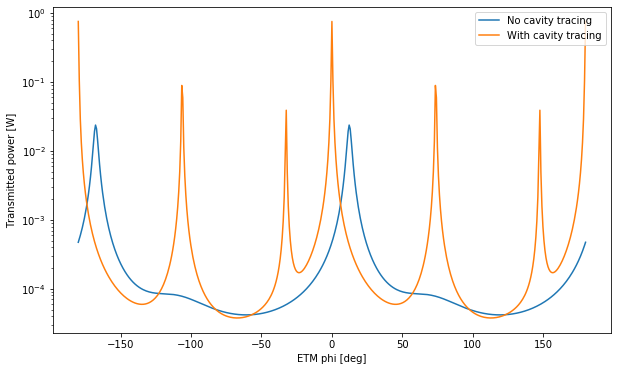

In [9]:
model = finesse.parse("""
l L0 P=1
s s0 L0.p1 ITM.p1

m ITM R=0.99 T=0.01 Rc=-2.5
s sCAV ITM.p2 ETM.p1 L=1
m ETM R=0.99 T=0.01 Rc=2.5

gauss L0.p1.o w0=1m z=-0.3

maxtem 4

pd trns ETM.p2.o

xaxis &ETM.phi (-180) 180 500 lin
""")
ifo = model.model

out_no_cav = model.run()

ifo.add(finesse.components.Cavity("FP", ifo.ITM.p2.o, ifo.ITM.p2.i))
out_cav = model.run()

fig = plt.figure(figsize=(10, 6))
plt.semilogy(out_no_cav.x1, out_no_cav["trns"], label="No cavity tracing")
plt.semilogy(out_cav.x1, out_cav["trns"], label="With cavity tracing")
plt.xlabel("ETM phi [deg]")
plt.ylabel("Transmitted power [W]")
plt.legend();

#### Ordering of cavity traces

If there are multiple cavities in a configuration then the order in which these are traced can influence the trace results (and thus HOM couplings). Any cavity traced first will set beam parameters throughout the system (except for in other cavities or at user-defined q values) corresponding to this propagated beam. These parameters cannot be overwritten so any subsequent traces from other cavities will not affect these already traced nodes.

In [10]:
michelson = finesse.parse("""
l L0 P=1
s s0 L0.p1 BS.p1 L=1

bs BS R=0.5 T=0.5

s sN BS.p2 ITMY.p1 L=0.5

m ITMY R=0.99 T=0.01 Rc=-2.5
s sY ITMY.p2 ETMY.p1 L=1
m ETMY R=0.99 T=0.01 Rc=2.5

s sE BS.p3 ITMX.p1 L=0.4

m ITMX R=0.99 T=0.01 Rc=-2.7
s sX ITMX.p2 ETMX.p2 L=1
m ETMX R=0.99 T=0.01 Rc=2.6

maxtem 4

pd out BS.p4.o

cav FPX ITMX.p2.o ITMX.p2.i
cav FPY ITMY.p2.o ITMY.p2.i
""")

print(michelson.model.beam_trace(store=False))

╒════════════════╤═══════════════════════════════════════════╤══════════════════╤════════════════════╕
│ Optical node   │ Beam parameter q                          │   Beam size [cm] │   Gouy phase [deg] │
╞════════════════╪═══════════════════════════════════════════╪══════════════════╪════════════════════╡
│ L0.p1.o        │ (-3.294736842105263+1.2352172978278702j)  │        0.184248  │          -1.21211  │
├────────────────┼───────────────────────────────────────────┼──────────────────┼────────────────────┤
│ BS.p1.i        │ (-2.294736842105263+1.2352172978278702j)  │        0.136461  │          -1.07699  │
├────────────────┼───────────────────────────────────────────┼──────────────────┼────────────────────┤
│ BS.p2.o        │ (-2.294736842105263+1.2352172978278702j)  │        0.136461  │          -1.07699  │
├────────────────┼───────────────────────────────────────────┼──────────────────┼────────────────────┤
│ ITMY.p1.i      │ (-1.7947368421052632+1.2352172978278702j) │        0.1

In [11]:
# can also pass in cavity instances themselves here (i.e. order=[michelson.model.FPY, michelson.model.FPX])
print(michelson.model.beam_trace(order=["FPY", "FPX"], store=False))

╒════════════════╤═══════════════════════════════════════════╤══════════════════╤════════════════════╕
│ Optical node   │ Beam parameter q                          │   Beam size [cm] │   Gouy phase [deg] │
╞════════════════╪═══════════════════════════════════════════╪══════════════════╪════════════════════╡
│ L0.p1.o        │ (-2+1j)                                   │        0.130131  │          -1.10715  │
├────────────────┼───────────────────────────────────────────┼──────────────────┼────────────────────┤
│ BS.p1.i        │ (-1+1j)                                   │        0.0823021 │          -0.785398 │
├────────────────┼───────────────────────────────────────────┼──────────────────┼────────────────────┤
│ BS.p2.o        │ (-1+1j)                                   │        0.0823021 │          -0.785398 │
├────────────────┼───────────────────────────────────────────┼──────────────────┼────────────────────┤
│ ITMY.p1.i      │ (-0.5+1j)                                 │        0.0

As with the `set_symmetric` option seen earlier, the cavity `order` can be passed to the beam trace arguments of a model via, e.g:

```python
ifo.beam_trace_args["order"] = ["FPY", "FPX"]
```

### Creating mismatches

One of the new features related to beam tracing is the `create_mismatch` method in `Model`:

In [12]:
help(ifo.create_mismatch)

Help on method create_mismatch in module finesse.model:

create_mismatch(node, w0_mm=0, z_mm=0) method of finesse.model.Model instance
    Sets the beam parameters such that a mismatch of the
    specified magnitude (in terms of :math:`w_0` and :math:`z`)
    exists at the given `node`.
    
    Parameters
    ----------
    node : :class:`.OpticalNode`
        The node to to create the mismatch at.
    
    w0_mm : float or sequence, optional
        The percentage magnitude of the mismatch in the waist size. This
        can also be a two-element sequence specifying the waist size mismatches
        for an astigmatic beam. Defaults to zero percent for both planes.
    
    z_mm : float or sequence, optional
        The percentage magntiude of the mismatch in the distance to
        the waist. This can also be a two-element sequence specifying the distance
        to waist mismatches for an astigmatic beam. Defaults to zero percent for
        both planes.



As the docstrings above imply, this can be used to set the beam parameters in a configuration such that
there is a mismatch of the specified value present at the given node. An example of using this is shown
below:

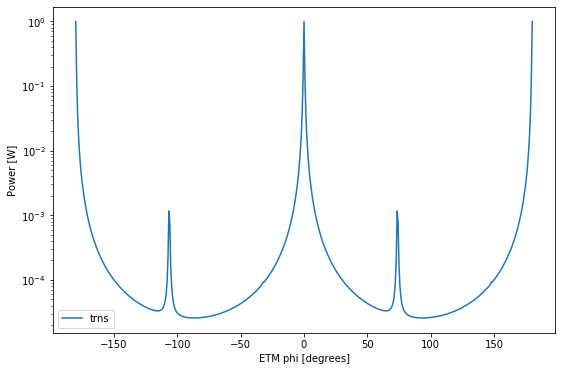

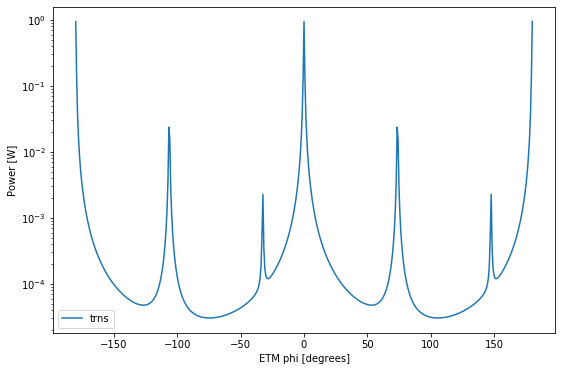

{finesse.detectors.powerdetector.PowerDetector: <Figure size 648x432 with 1 Axes>}

In [13]:
model = finesse.parse("""
l L0 P=1
s s0 L0.p1 ITM.p1

m ITM R=0.99 T=0.01 Rc=-2.5
s sCAV ITM.p2 ETM.p1 L=1
m ETM R=0.99 T=0.01 Rc=2.5

cav FP ITM.p2.o ITM.p2.i

maxtem 4

pd trns ETM.p2.o

xaxis &ETM.phi (-180) 180 500 lin
""")
# ifo is initially mode-matched
ifo = model.model

# create a mismatch of 5% in w0 and 1% in z at the first surface of ITM
ifo.create_mismatch(ifo.ITM.p1.i, 5, 1)
model.run().plot(logy=True, figsize_scale=1.5)

# create a mismatch of 20% in w0 and -13% in z at the first surface of ITM
ifo.create_mismatch(ifo.ITM.p1.i, 20, -13)
model.run().plot(logy=True, figsize_scale=1.5)

### Profiling

Below we show the top 25 functions by time spent inside them for a beam trace of an aLIGO type file.

**Note** - that for code which takes little time to run (such as this) the logging contributes a non-negligible amount. Running the beam trace on this file with `timeit`
(no logging) gives around half the total time shown here.

In [14]:
import cProfile
import pstats

with open("../../playground/aligo/design.kat", 'r') as f:
    CODE = f.read()

aligo_model = finesse.parse(CODE, True)
aligo = aligo_model.model

cProfile.run("aligo.beam_trace()", "aligo_beamtrace.prof")
p = pstats.Stats("aligo_beamtrace.prof")
p.sort_stats("time")
p.print_stats(25);

Wed Oct  9 13:35:41 2019    aligo_beamtrace.prof

         237182 function calls (236158 primitive calls) in 0.184 seconds

   Ordered by: internal time
   List reduced from 183 to 25 due to restriction <25>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   1032/8    0.020    0.000    0.171    0.021 /Users/sjr/Documents/phd/finesse_development/finesse/tracing/tracer.py:270(__run_simtrace)
     1482    0.010    0.000    0.038    0.000 /Users/sjr/Documents/phd/finesse_development/finesse/components/node.py:532(space)
     8597    0.008    0.000    0.011    0.000 /Users/sjr/Documents/phd/finesse_development/finesse/components/cavity.py:423(is_critical)
     8597    0.007    0.000    0.007    0.000 /Users/sjr/Documents/phd/finesse_development/finesse/components/cavity.py:413(is_stable)
     1024    0.007    0.000    0.067    0.000 /Users/sjr/Documents/phd/finesse_development/finesse/model.py:1451(path)
     1024    0.007    0.000    0.046    0.000 /Users/sjr/Docum

### Logging

Options exist within the `Model` class to log various pieces of information about the beam trace whilst it's running. By default this only tells
the user when beam traces are triggered, other logging statements must be activated with the relevant flags (this is for optimisation purposes).

The following logging flags are available within the `beam_trace_logging` field (a `dataclass`) of a Model:

- `trace_info` --- gives details on where the tracing algorithm currently is, what the successor nodes are, what beam splitter branch nodes have been encountered etc.
- `ABCDs` --- prints current node q values, the ABCD matrices being applied across the current component and the values of q for nodes being set.
- `results` --- displays the tabulated results from a trace.

In [15]:
finesse.LOGGER.setLevel("INFO")

# using the cavity model from 'Tracing with cavities' section
ifo.beam_trace_logging.trace_info = True
ifo.beam_trace_logging.ABCDs = True
# we can force a retrace of the model such that a beam trace is performed on the next call
# even if no parameters have changed which would warrant a retrace
ifo.force_retrace()
ifo.beam_trace();

finesse.model            :INFO    : Beam trace triggered on <finesse.model.Model object at 0x11cedc518>
finesse.model            :INFO    : Tracing the beam from cavity: FP
finesse.tracing.tracer   :INFO    : 	Propagating trace from ITM.p2.o with successors: ['ETM.p1.i']
finesse.tracing.tracer   :INFO    : 		Setting tangential beam parameter of ETM.p1.i ...
finesse.tracing.tracer   :INFO    : 			ITM.p2.o.qx =  (-0.5+1j)
finesse.tracing.tracer   :INFO    : 			ABCD_x at sCAV for coupling ITM.p2.o -> ETM.p1.i = [[1.0, 1.0], [0.0, 1.0]]
finesse.tracing.tracer   :INFO    : 			nr1 = 1, nr2 = 1
finesse.tracing.tracer   :INFO    : 			Computed ETM.p1.i.qx = (0.5+1j)
finesse.tracing.tracer   :INFO    : 		Setting sagittal beam parameter of ETM.p1.i ...
finesse.tracing.tracer   :INFO    : 			ITM.p2.o.qy =  (-0.5+1j)
finesse.tracing.tracer   :INFO    : 			ABCD_y at sCAV for coupling ITM.p2.o -> ETM.p1.i = [[1.0, 1.0], [0.0, 1.0]]
finesse.tracing.tracer   :INFO    : 			nr1 = 1, nr2 = 1
finesse.traci

### Questions/Concerns

- Smarter / more customisable beam tracing options?
  - ability to ``flag'' nodes (on a beam splitter) where q should be set to the average (see next point) of the two interfering beam parameters?
  - more than just the average, allow injection of custom function based on the two interfering q values?
- Better ordering of printed beam parameter tables?
  - currently do a depth first search using [`networkx.dfs_preorder_nodes`](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.traversal.depth_first_search.dfs_preorder_nodes.html#networkx.algorithms.traversal.depth_first_search.dfs_preorder_nodes) with the source node set to the first laser output node found (if any) and print the table of parameters based on this order...
  - ... could try other traversal functions - breadth first search should give transmission first then reflections after (maybe better?).
- Non-symmetric tracing options?
  - rather than preventing **all** node.opposite qs being set to $-q*$ we could have options to indicate at which node(s) in the
    configuration to stop symmetric tracing.
- Make properties of a `BeamParam` model parameters (or have an option to)?
  - It might be nice to be able to do something like the code below, i.e. scan the waist-size or distance to waist parameter of some
    gauss command which has been set somewhere in the system.

```
gauss gL0 L0.p1.0 w0=0.01 z=0

# ...

xaxis &gL0.w0 0.01 0.01 100 lin
```

  - The code is not set up to allow this currently, however, and would probably require significant changes to some of the gauss command and `BeamParam` code.